In [5]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=b2cf2fd2ae8576c53c3742f9944984e256cbf533a15ffcdf2b93f3dc077b2218
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninsta

Trong phần trước, chúng tôi đã giới thiệu những công cụ cơ bản để xây dựng mạng học sâu và kiểm soát năng lực của nó thông qua việc giảm chiều dữ liệu, suy giảm trọng số và dropout. Giờ bạn đã sẵn sàng để ứng dụng tất cả những kiến thức này vào thực tiễn bằng cách tham gia một cuộc thi trên Kaggle. Dự đoán giá nhà là một bài toán tuyệt vời để bắt đầu: dữ liệu tương đối khái quát, không có cấu trúc cứng nhắc nên không đòi hỏi những mô hình đặc biệt như các bài toán có dữ liệu ảnh và âm thanh. Tập dữ liệu này được thu thập bởi Bart de Cock vào năm 2011 [DeCock, 2011], lớn hơn rất nhiều so với tập dữ liệu giá nhà Boston nổi tiếng của Harrison và Rubinfeld (1978). Nó có nhiều mẫu và đặc trưng hơn, chứa thông tin về giá nhà ở Ames, Indiana trong khoảng thời gian từ 2006-2010.

Trong mục này, chúng tôi sẽ hướng dẫn bạn một cách chi tiết các bước tiền xử lý dữ liệu, thiết kế mô hình, lựa chọn và điều chỉnh siêu tham số. Chúng tôi mong rằng thông qua việc thực hành, bạn sẽ có thể quan sát được tác động của việc kiểm soát năng lực mô hình, trích xuất đặc trưng, v.v. trong thực tiễn. Kinh nghiệm này rất quan trọng để bạn có được trực giác của một nhà khoa học dữ liệu.

In [6]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 5.7.1. Tải dữ liệu

Xuyên suốt cuốn sách, chúng ta sẽ đào tạo và thử nghiệm các mô hình trên nhiều bộ dữ liệu đã tải xuống. Ở đây, chúng ta thực hiện hai chức năng tiện ích để tải xuống tệp và giải nén tệp zip hoặc tar. Một lần nữa, chúng ta trì hoãn việc triển khai chúng vào Mục 23.7 .

In [7]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

# 5.7.2. Kaggle

Kaggle là một nền tảng phổ biến tổ chức các cuộc thi máy học. Mỗi cuộc thi tập trung vào một tập dữ liệu và nhiều cuộc thi được tài trợ bởi các bên liên quan, những người trao giải thưởng cho các giải pháp chiến thắng. Nền tảng này giúp người dùng tương tác thông qua các diễn đàn và mã được chia sẻ, thúc đẩy cả sự hợp tác và cạnh tranh. Mặc dù việc theo đuổi bảng xếp hạng thường vượt khỏi tầm kiểm soát, với việc các nhà nghiên cứu tập trung một cách thiển cận vào các bước tiền xử lý thay vì đặt ra các câu hỏi cơ bản, nhưng cũng có giá trị to lớn về tính khách quan của một nền tảng tạo điều kiện so sánh định lượng trực tiếp giữa các phương pháp cạnh tranh cũng như chia sẻ mã để mọi người có thể tìm hiểu những gì đã làm và không làm việc. Nếu bạn muốn tham gia một cuộc thi Kaggle, trước tiên bạn cần đăng ký một tài khoản 

Trên trang cuộc thi dự đoán giá nhà, bạn có thể tìm thấy tập dữ liệu (trong tab “Dữ liệu”), gửi dự đoán và xem xếp hạng của mình. URL ở ngay tại đây:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

#5.7.3. Truy cập và đọc bộ dữ liệu

Lưu ý rằng dữ liệu cuộc thi được tách thành tập huấn luyện và tập kiểm tra. Mỗi bản ghi bao gồm giá trị tài sản của ngôi nhà và các thuộc tính như loại đường phố, năm xây dựng, loại mái nhà, tình trạng tầng hầm, v.v. Các tính năng bao gồm nhiều loại dữ liệu khác nhau. Ví dụ: năm xây dựng được biểu thị bằng một số nguyên, loại mái nhà được biểu thị bằng các phép gán phân loại rời rạc và các tính năng khác bằng các số dấu phẩy động. Và đây là nơi thực tế làm mọi thứ phức tạp hơn: đối với một số ví dụ, một số dữ liệu bị thiếu hoàn toàn với giá trị bị thiếu được đánh dấu đơn giản là “na”. Giá của mỗi ngôi nhà chỉ được bao gồm cho bộ đào tạo (dù sao đó cũng là một cuộc thi). Chúng ta sẽ muốn phân vùng tập huấn luyện để tạo tập hợp xác thực, nhưng chúng tôi chỉ có thể đánh giá các mô hình của mình trên tập kiểm tra chính thức sau khi tải các dự đoán lên Kaggle

Để bắt đầu, chúng tôi sẽ đọc và xử lý dữ liệu bằng cách sử dụng pandas, mà chúng tôi đã giới thiệu trong Phần 2.2 . Để thuận tiện, chúng tôi có thể tải xuống và lưu trữ bộ dữ liệu nhà ở Kaggle. Nếu một tệp tương ứng với tập dữ liệu này đã tồn tại trong thư mục bộ nhớ cache và SHA-1 của nó khớp với sha1_hash, thì mã của chúng tôi sẽ sử dụng tệp đã lưu trong bộ nhớ cache để tránh làm tắc nghẽn Internet của bạn do tải xuống dư thừa.

In [8]:
"""
  Đầu tiên tạo 1 Class để lưu trữ và tải dữ liệu về từ kaggle
kế thừa từ class d2l.DataModule.

  Về class Download em vẫn chưa hiểu lắm mà em thấy cần ưu tiên 
xem những triển khai ở dưới trước nên để tìm hiểu về sau ạ.

"""

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

Tập dữ liệu huấn luyện bao gồm 1460 ví dụ, 80 tính năng và 1 nhãn, trong khi dữ liệu xác thực chứa 1459 ví dụ và 80 tính năng.

In [9]:
"""
Xem thử định dạng, kích thước tập dữ liệu mà ta sắp xử lý
1. Với tập train có 1460 sample, 80 feature (đầu vào - X), 1 label (y)
2. Với tập test có 1459 sample, 80 feature
"""
data = KaggleHouse(batch_size = 64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


# 5.7.4. Tiền xử lý dữ liệu

Chúng ta hãy xem bốn tính năng đầu tiên và hai tính năng cuối cùng cũng như nhãn (Giá bán) từ bốn ví dụ đầu tiên.

In [10]:
"""
Xem  thử: 
1. 4 tính năng đầu tiên và 2 tính năng cuối cùng 
2. Và nhãn (Giá bán) của chúng với 4 ví dụ đầu tiên.
"""
print(data.raw_train.iloc[:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


Chúng ta có thể thấy rằng trong mỗi ví dụ, tính năng đầu tiên là ID. Điều này giúp mô hình xác định từng ví dụ đào tạo. Mặc dù điều này thuận tiện, nhưng nó không mang bất kỳ thông tin nào cho mục đích dự đoán. Do đó, chúng ta sẽ xóa nó khỏi tập dữ liệu trước khi đưa dữ liệu vào mô hình. Ngoài ra, với nhiều loại dữ liệu khác nhau, chúng ta sẽ cần xử lý trước dữ liệu trước khi có thể bắt đầu lập mô hình.

Hãy bắt đầu với các tính năng số. Đầu tiên, chúng ta áp dụng phương pháp phỏng đoán, thay thế tất cả các giá trị còn thiếu bằng giá trị trung bình của đối tượng địa lý tương ứng. Sau đó, để đặt tất cả các tính năng trên một thang đo chung, chúng ta chuẩn hóa dữ liệu bằng cách thay đổi tỷ lệ các tính năng về giá trị trung bình bằng 0 và phương sai đơn vị:
$$
x \leftarrow \frac{x - \mu}{\sigma},
$$

Với $\mu$ và $\sigma$ lần lượt biểu thị giá trị trung bình và độ lệch chuẩn. Để xác minh rằng điều này thực sự biến đổi tính năng (biến) của chúng ta sao cho nó có phương sai đơn vị và trung bình bằng 0, hãy lưu ý rằng
$$E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$$
và do đó
$$
E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2
$$

Theo trực giác, chúng tôi chuẩn hóa dữ liệu vì hai lý do. Đầu tiên, nó tỏ ra thuận tiện cho việc tối ưu hóa. Thứ hai, bởi vì chúng ta không biết trước các tính năng nào sẽ có liên quan, chúng ta không muốn xử phạt các hệ số được gán cho một tính năng nhiều hơn bất kỳ tính năng nào khác.

Tiếp theo chúng ta xử lý các giá trị rời rạc. Điều này bao gồm các tính năng như “MSZoning”. Chúng ta thay thế chúng bằng mã hóa one-hot giống như cách mà chúng ta đã chuyển đổi nhãn đa lớp trước đó thành vectơ (xem Phần 4.1.1 ). Chẳng hạn, “MSZoning” giả định các giá trị “RL” và “RM”. Bỏ tính năng “MSZoning”, hai tính năng chỉ báo mới “MSZoning_RL” và “MSZoning_RM” được tạo với các giá trị là 0 hoặc 1. Theo mã hóa one-hot, nếu giá trị ban đầu của “MSZoning” là “RL”, thì “ MSZoning_RL” là 1 và “MSZoning_RM” là 0.Gói pandas tự động thực hiện việc này cho chúng ta.

In [29]:
"""
  Do dữ liệu còn rất nhiều loại nên ta phải tiền xử lý trước khi 
đưa vào training.

1. Với feature dư thừa không cần thiết ví dụ "ID" ta có thể xóa đi
  Dùng pd.concat để drop đi cột or hàng ta không cần.

2. Với các dữ liệu số mà thiếu, ta thay thế các giá trị 
còn thiếu bằng giá trị trung bình. Đầu tiên, để tất cả feature dạng 
số về cùng 1 khoảng giá trị, ta thực hiện chuyển đổi như công thức
trên. Sau đó gán 0 (giá trị trung bình mới) cho các giá trị còn thiếu.
Các bước:

  - Tìm các chỉ mục của feature dạng số
  - Từ đó, ta áp dụng công thức trên với tất cả các feature có chỉ 
    mục vừa tìm 
  - Gán 0 cho các giá trị có thiếu.

3. Với các dữ liệu rời rạc ta sẽ phân bố theo kiểu one-hot 
  ví dụ:
  Feature màu sơn (hồng, đỏ) thì sẽ thành:
  2 Feature màu sơn_hồng (1, 0)
            màu sơn_đỏ   (0, 1)
  Hàm get_dummies của pandas sẽ gúp ta làm việc đó.

4. Gán lại các giá trị đã lọc và xử lý từ raw vào chuẩn để sử dụng.

### Thắc mắc ###
1. Việc điền đầy dữ liệu thiếu, thì ta chuẩn hóa trước rồi mới điền
  thì khi chuẩn hóa các dữ liệu N/A nó sẽ tính vào công thức như
  thế nào ạ ?!

2. Nếu việc thiếu cả dữ liệu ở các features rời rạc thì sao ạ ?!
  Cũng chuyển thành one-hot hay được xử lý khác ạ ?!

"""
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

Bạn có thể thấy rằng chuyển đổi này làm tăng số lượng tính năng từ 79 lên 331 (không bao gồm các cột ID và nhãn).

In [27]:
data.preprocess()
data.train.shape
print(data.train.iloc[:4, [0,1,2,3,-3,-2,-1]])

   MSSubClass  LotFrontage   LotArea  OverallQual  SaleCondition_Partial  \
0    0.067320    -0.184443 -0.217841     0.646073                      0   
1   -0.873466     0.458096 -0.072032    -0.063174                      0   
2    0.067320    -0.055935  0.137173     0.646073                      0   
3    0.302516    -0.398622 -0.078371     0.646073                      0   

   SaleCondition_nan  SalePrice  
0                  0     208500  
1                  0     181500  
2                  0     223500  
3                  0     140000  


# 5.7.5. Đo lỗi

Để bắt đầu, chúng ta sẽ đào tạo một mô hình tuyến tính với tổn thất bình phương. Không có gì đáng ngạc nhiên, mô hình tuyến tính của chúng tôi sẽ không dẫn đến một bài nộp giành chiến thắng trong cuộc thi nhưng nó cung cấp khả năng kiểm tra độ chính xác để xem liệu có thông tin có ý nghĩa trong dữ liệu hay không. Nếu chúng tôi không thể làm tốt hơn ngoài việc đoán ngẫu nhiên ở đây, thì rất có thể chúng tôi gặp lỗi xử lý dữ liệu. Và nếu mọi thứ hoạt động, mô hình tuyến tính sẽ đóng vai trò là đường cơ sở cho chúng ta một số trực giác về mức độ gần gũi của mô hình đơn giản với các mô hình được báo cáo tốt nhất, cho chúng ta biết chúng ta nên mong đợi mức tăng bao nhiêu từ các mô hình đẹp hơn.

Với giá nhà, cũng như giá cổ phiếu, chúng ta quan tâm đến số lượng tương đối nhiều hơn số lượng tuyệt đối. Vì vậy chúng ta có xu hướng quan tâm nhiều hơn đến sai số tương đối $\frac{y - \hat{y}}{y}$ hơn về lỗi tuyệt đối $y - \hat{y}$. Ví dụ: nếu dự đoán của chúng tôi sai lệch 100.000 USD khi ước tính giá một ngôi nhà ở Nông thôn Ohio, nơi giá trị của một ngôi nhà điển hình là 125.000 USD, thì có lẽ chúng tôi đang làm một công việc tồi tệ. Mặt khác, nếu chúng ta sai số này ở Los Altos Hills, California, thì đây có thể là một dự đoán chính xác đến kinh ngạc (ở đó, giá nhà trung bình vượt quá 4 triệu USD).

Một cách để giải quyết vấn đề này là đo lường sự khác biệt theo logarit của các ước tính giá. Trên thực tế, đây cũng là thước đo lỗi chính thức được cuộc thi sử dụng để đánh giá chất lượng bài dự thi. Rốt cuộc, một giá trị nhỏ $\delta$ vì |$\log y - \log \hat{y}| \leq \delta$  dịch sang $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. Điều này dẫn đến sai số bình phương trung bình gốc sau đây giữa logarit của giá dự đoán và logarit của giá nhãn:

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.
$$

In [13]:
"""
  Sau khi đã xử lý về Feature, tiếp đến là Label. Ta modify lại hàm
get_dataloader:

1. Kiểm tra xem hàm được gọi để train hay để kiểm tra val
2. Nếu là train thì data = self.train, nếu không thì ngược lại
3. Khởi tạo get_tensor là một lambda - tương tự như hàm với nhiệm vụ
  trả về giá trị của tham số truyền vào và gán dtype = float32
4. Khởi tạo tensor bao gồm
  - Các feature chính là data bỏ đi cột 'label'
  - Label đã qua xử lý:
    + get_tensor cột 'label' 
    + tính logarit cho từng phần tử
    + reshape lại thành 1 cột cho đúng định dạng vì get_tensor làm 
      mất định dạng ban đầu.
5. Trả về tensors chưa bộ dữ liệu hoàn chỉnh.

### Thắc mắc ###
1. Hàm get_tensorloader(), ở bài trước ngta có định nghĩa như sau:

def get_tensorloader(self, tensors, train, indices = slice(0, None)):
  tensors = tuple(a[indices] for a in tensors)
  dataset = torch.utils.data.TensorDataset(*tensors)
  return torch.utils.data.DataLoader(dataset, self.batch_size,
                                      shuffle=train)


"""
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return 
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

# 5.7.6. $K$-Fold Cross-Validation

Nếu bạn đang đọc cuốn sách này theo đúng thứ tự thì có thể bạn sẽ nhớ ra rằng kiểm định chéo gập k-lần đã từng được giới thiệu khi ta thảo luận về cách lựa chọn mô hình (: numref: sec_model_selection). Ta sẽ ứng dụng kỹ thuật này để lựa chọn thiết kế mô hình và điều chỉnh các siêu tham số. Trước tiên ta cần một hàm trả về phần thứ  $i^{th}$
  của dữ liệu trong kiểm định chéo gập k-lần. Việc này được tiến hành bằng cách cắt chọn (slicing) phần thứ $i^{th}$ để làm dữ liệu kiểm định và dùng phần còn lại làm dữ liệu huấn luyện. Cần lưu ý rằng đây không phải là cách xử lý dữ liệu hiệu quả nhất và ta chắc chắn sẽ dùng một cách khôn ngoan hơn để xử lý một tập dữ liệu có kích thước lớn hơn nhiều. Nhưng sự phức tạp được thêm vào này có thể làm rối mã nguồn một cách không cần thiết, vì vậy để đơn giản hóa vấn đề ở đây ta có thể an toàn bỏ qua.

In [14]:
"""
Chia k_fold data:
1. Chia data làm K phần, với K lần học
2. Với lần học thứ K thì phần nhỏ thứ K sẽ được làm tập val

 Dưới đây là hàm với đầu vào là dữ liệu, trả về K tập dữ liệu đã được
chia

### Thắc mắc ###
1. Chưa hiểu về data.train.loc[idx]
"""
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

Val-error trung bình được trả về mỗi khi ta đào tạo K lần trong K-fold cross validation

In [31]:
"""
Thực hiện lặp K lần, với K tập dữ liệu

### Thắc măc ###
1. Với việc model ở trong vòng for thì ở đây ta đang tạo ra K model
  với K tập dữ liệu được chia khác nhau. Thì nếu để model ra ngoài
  có tương đương với việc epoch = epoch trước đó * k không ạ ?!

2. Mục đích của việc chia này là gì ạ ?!

3. Công thức loss ở trên em chưa thấy được triển khai mà mới chỉ đổi
  y sang log(y) thì là đã được nhúng sẵn r ạ ?!

4. data_fold được chia bởi k_fold_data mà em thấy nó chỉ append 
  data.train vậy thì cái data.val của raw_val mà mình down trên web
  xuống không được dùng ạ ?!
"""
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
        print(f"fold {i}, train rmse: {float(model.board.data['train_loss'][-1].y)}, valid rmse: {float(model.board.data['val_loss'][-1].y)}")
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

# 5.7.7. Lựa chọn model

Trong ví dụ này, chúng ta chọn một bộ siêu tham số chưa được tinh chỉnh và để dành việc cải thiện mô hình cho bạn đọc. Để tìm ra được một bộ siêu tham số tốt có thể sẽ tốn khá nhiều thời gian tùy thuộc vào số lượng siêu tham số mà ta muốn tối ưu. Nếu được sử dụng đúng cách, phương pháp kiểm định chéo gập k-lần sẽ có tính ổn định cao khi thực hiện với nhiều thử nghiệm. Tuy nhiên, nếu thử quá nhiều các lựa chọn siêu tham số thì phương pháp này có thể thất bại vì ta có thể chỉ đơn thuần gặp may ở một cách chia tập kiểm định phù hợp với bộ siêu tham số đó.

fold 0, train rmse: 0.15881408833795124, valid rmse: 0.14865438789129257
fold 1, train rmse: 0.08634433274467786, valid rmse: 0.11466318815946579
fold 2, train rmse: 0.06335649639368057, valid rmse: 0.08399730324745178
fold 3, train rmse: 0.061181333329942494, valid rmse: 0.051987215876579285
fold 4, train rmse: 0.046053224760625094, valid rmse: 0.06489379182457924
average validation log mse = 0.09283917739987373


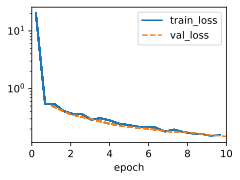

In [34]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)